## $\text{Code Documentation}$

##  $\underline{\text{ 1) Data Stream Simulation Part}}$

$\textbf{generate_synthetic_data_stream(int: n_samples) function}$
This function generates a synthetic time-series data stream with a sinusoidal pattern, random noise, and occasional anomalies.

Parameters:
n_samples (int): The total number of data points to generate in the data stream. Defaults to 1000.
Process:
The function iterates to generate n_samples points with a sinusoidal seasonal pattern plus random noise.
A small percentage of data points are augmented with larger random values, simulating anomalies.
Returns:
A NumPy array of shape (n_samples, 1) containing the generated data stream.

## $\underline{\text{2) Anomaly Detection Part}}$

$\textbf{a. IsolationTree Class:}$
This class represents an individual Isolation Tree for the Isolation Forest model, which performs random data partitioning.

Initialization:
height_limit (int): The maximum height (depth) of the tree.
Attributes:
n_nodes (int): Counter for the number of nodes in the tree.
root: Reference to the root of the Isolation Tree.
fit(self, data, current_height):
Recursively builds the tree by selecting random features and random split values.
Parameters:
data (np.ndarray): A NumPy array representing the data to fit.
current_height (int): Tracks the current depth during recursion.
Returns:
A dictionary with details about the split feature and split value, and recursively built left and right sub-trees.
Base Cases:
Ends recursion if a single data point is left or if current_height exceeds height_limit.
path_length(self, x, tree, current_height):
Recursively computes the path length for a given data point x by traversing the tree until reaching a leaf.
Parameters:
x (np.ndarray): The data point for which to calculate the path length.
tree (dict): The current node of the tree.
current_height (int): Tracks the current depth.
Returns:
An integer representing the path length of x in the tree.

$\textbf{b. IsolationForest Class:}$
This class represents the Isolation Forest, which is composed of multiple Isolation Trees, each fitted on a random subset of data points.

Initialization:
n_trees (int): The number of Isolation Trees in the forest.
sample_size (int): The number of samples used to fit each tree.
fit(self, X):
Trains the Isolation Forest by creating and fitting each Isolation Tree on a random subset of data.
Parameters:
X (np.ndarray): The dataset to fit, where rows represent individual data points.
Process:
For each tree, it samples sample_size data points and constructs the tree with a height limit based on the sample size.
anomaly_score(self, X):
Computes the anomaly scores for a set of data points by averaging the path lengths across all trees.
Parameters:
X (np.ndarray): The dataset for which to calculate anomaly scores.
Process:
For each data point, computes the average path length across all trees.
Uses the average path length to calculate the anomaly score.
Returns:
A NumPy array of anomaly scores, with higher values indicating greater anomaly likelihood.

##  $\underline{3) \text{Visualization Part}}$
This visualization section includes two plots that show the data stream before and after anomaly detection, highlighting the detected anomalies.

Figure Size Configuration:

plt.figure(figsize=(12, 6)): Creates a figure with dimensions 12x6 for the plots.
Plot Before Detection:

plt.subplot(2, 1, 1): Creates the first subplot.
plt.plot(data_stream, label="Data Stream"): Plots the raw data stream with the label "Data Stream."
plt.title("Data Stream Before Anomaly Detection"): Sets the title for the raw data stream plot.
Plot After Detection (Marking Anomalies):

plt.subplot(2, 1, 2): Creates the second subplot.
plt.plot(data_stream, label="Data Stream"): Plots the data stream again.
plt.scatter(np.arange(len(data_stream))[anomalies], data_stream[anomalies], color='r', label="Anomaly"): Marks the detected anomalies in red.
plt.title("Data Stream with Detected Anomalies"): Sets the title for the plot with anomalies highlighted.
plt.legend(): Adds a legend to distinguish between the data stream and the anomalies.
Display:

plt.tight_layout(): Adjusts layout to avoid overlapping elements.
plt.show(): Displays the plots.

## $\text{Algorithm Selection}$:
### $\text{For this project, I've selected the Isolation Forest Algorithm to detect anomalies}$

### $\text{Algorithm Brief Description:}$
Isolation Forest is an unsupervised algorithm used to detect anomalous data points within a dataset. It works by isolating observations by randomly selecting a feature and a split value between the minimum and maximum values of the selected feature. Anomalies are observations that require fewer random splits to isolate, as they differ significantly from the rest of the data. This algorithm is particularly effective at identifying unexpected spikes, deviations in time-series patterns, or outliers in otherwise structured data.


In [43]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

### $\text{Data Stream Simulation:}$

In [65]:
import numpy as np
import random

# Function to generate synthetic data stream
def generate_synthetic_data_stream(n_samples=1000):
    data = []
    for t in range(n_samples):
        # Seasonal sinusoidal pattern
        seasonal_pattern = 10 * np.sin(t / 20)

        # Random noise added to each point
        noise = random.uniform(-2, 2)

        # Combined pattern and noise to form the value
        value = seasonal_pattern + noise

        # Introduce random anomalies occasionally
        if random.random() > 0.98:
            value += random.uniform(15, 40)

        data.append(value)

    return np.array(data).reshape(-1, 1)

# Generate synthetic data
data_stream = generate_synthetic_data_stream(n_samples=1000)


### $\text{Anomaly Detection (Isolation Tree):}$

In [66]:
class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.node_count = 0
        self.root_node = None

    def fit(self, data, current_depth=0):
        # Stop recursion if only one data point is left or max depth is reached
        if len(data) <= 1 or current_depth >= self.max_depth:
            return None

        self.node_count += 1

        # Randomly select a feature and a split threshold
        feature_index = np.random.randint(0, data.shape[1])
        feature_min, feature_max = data[:, feature_index].min(), data[:, feature_index].max()

        # Stop splitting if feature values are identical
        if feature_min == feature_max:
            return None

        # Random split threshold within the range of the feature
        split_value = random.uniform(feature_min, feature_max)

        # Split the data based on the selected threshold
        left_split = data[data[:, feature_index] < split_value]
        right_split = data[data[:, feature_index] >= split_value]

        # Recursively build the left and right branches
        return {
            'feature_index': feature_index,
            'split_value': split_value,
            'left_branch': self.fit(left_split, current_depth + 1),
            'right_branch': self.fit(right_split, current_depth + 1)
        }

    def path_length(self, sample, node, current_depth=0):
        # Base case: If node is None, return the current depth
        if node is None:
            return current_depth

        # Navigate the tree based on the sample's value for the split feature
        feature_index = node['feature_index']
        if sample[feature_index] < node['split_value']:
            return self.path_length(sample, node['left_branch'], current_depth + 1)
        else:
            return self.path_length(sample, node['right_branch'], current_depth + 1)


### $\text{Anomaly Detection (Isolation Forest):}$

In [76]:
class IsolationForest:
    def __init__(self, num_trees=100, sample_size=256):
        self.num_trees = num_trees
        self.sample_size = sample_size
        self.forest = []

    def fit(self, data):
        max_depth = math.ceil(math.log2(self.sample_size))
        for _ in range(self.num_trees):
            # Sample a random subset of the data
            sample_indices = np.random.choice(len(data), self.sample_size, replace=False)
            data_sample = data[sample_indices]
            tree = IsolationTree(max_depth)
            tree.root_node = tree.fit(data_sample)
            self.forest.append(tree)

    def anomaly_score(self, data):
        # Constant to normalize the path length
        normalization_factor = 2 * (math.log(self.sample_size - 1) + 0.5772156649) - (2 * (self.sample_size - 1) / self.sample_size)
        scores = []

        # Calculate the anomaly score for each data point
        for sample in data:
            path_lengths = [tree.path_length(sample, tree.root_node) for tree in self.forest]
            avg_path_length = np.mean(path_lengths)
            scores.append(2 ** (-avg_path_length / normalization_factor))  # Anomaly score calculation

        return np.array(scores)


### $\text{Generation of synthetic Data Stream:}$

In [77]:
# Generate synthetic data
data_stream = generate_synthetic_data_stream(n_samples=1000)

# Fit Isolation Forest
iso_forest = IsolationForest(num_trees=100, sample_size=256)
iso_forest.fit(data_stream)

# Get anomaly scores
scores = iso_forest.anomaly_score(data_stream)

# Mark anomalies
threshold = 0.6
anomalies = scores > threshold

### $\text{Visualized Comparison of Data Stream before and after anomaly detection:}$

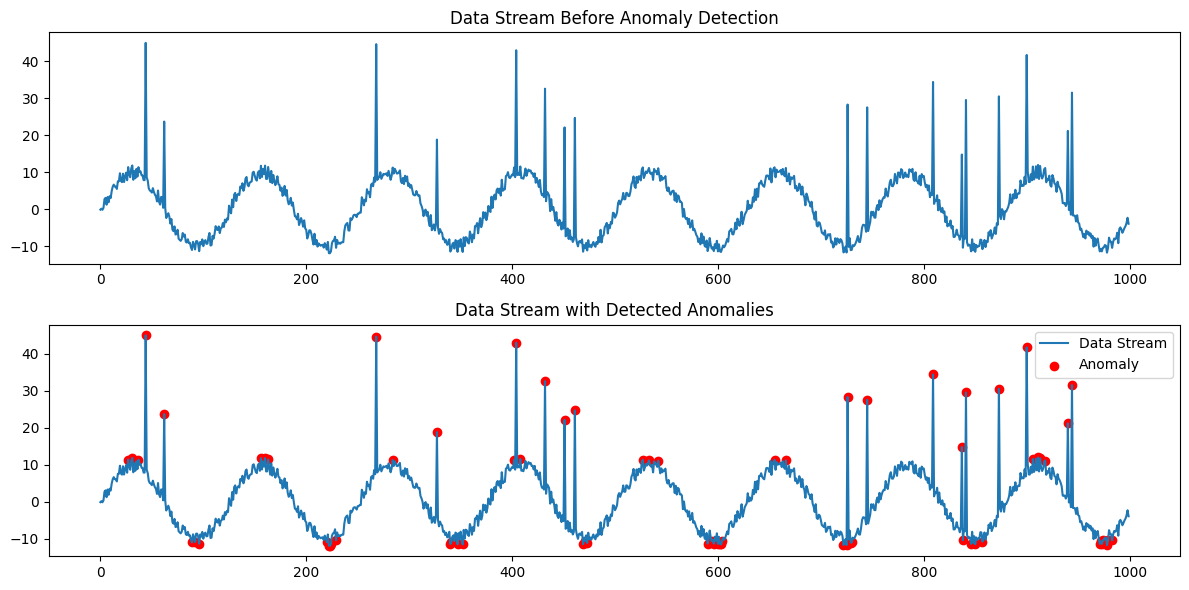

In [78]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot before detection (raw data)
plt.subplot(2, 1, 1)
plt.plot(data_stream, label="Data Stream")
plt.title("Data Stream Before Anomaly Detection")
plt.grid(False)

# Plot after detection (marking anomalies)
plt.subplot(2, 1, 2)
plt.plot(data_stream, label="Data Stream")
plt.scatter(np.arange(len(data_stream))[anomalies], data_stream[anomalies], color='r', label="Anomaly")
plt.title("Data Stream with Detected Anomalies")
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()